In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
import seaborn as sns
from importlib import reload
from itertools import chain
from scipy.sparse import csr_matrix

import utils_guide_calling as gc

In [2]:
reload(gc)

<module 'utils_guide_calling' from '/Users/janabraunger/Documents/Projects/scCRISPR/crispat_analysis/python/utils_guide_calling.py'>

In [3]:
data_dir = "../../data/"
gc_dir = "../../data/guide_calling/"
fig_dir = "../../figures/guide_calling_schraivogel/"

# gRNA distributions

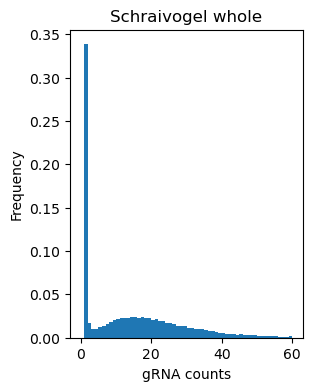

In [4]:
# plot the gRNA distribution for the whole data set
counts = pd.read_csv(data_dir + 'Schraivogel/whole/gRNA_counts.csv').set_index('gRNA')
all_values = pd.concat([counts[col] for col in counts.columns])
nonzero_values = all_values[all_values != 0]

plt.figure(figsize=(3,4))
plt.hist(nonzero_values, bins = 60, range = (0,60), density = True)  
plt.xlabel('gRNA counts')
plt.ylabel('Frequency')
plt.title('Schraivogel whole')
plt.savefig(fig_dir + 'Schraivogel_whole_gRNA_distribution.png', dpi = 500, bbox_inches="tight")
plt.show()

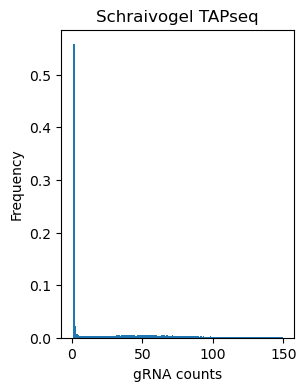

In [5]:
# plot the gRNA distribution for the TAPseq screen
counts = pd.read_csv(data_dir + 'Schraivogel/TAP/gRNA_counts.csv').set_index('gRNA')
all_values = pd.concat([counts[col] for col in counts.columns])
nonzero_values = all_values[all_values != 0]

plt.figure(figsize=(3,4))
plt.hist(nonzero_values, bins = 150, range = (0,150), density = True)  
plt.xlabel('gRNA counts')
plt.ylabel('Frequency')
plt.title('Schraivogel TAPseq')
plt.savefig(fig_dir + 'Schraivogel_TAP_gRNA_distribution.png', dpi = 500, bbox_inches="tight")
plt.show()

# Guide assignment intersections 

In [6]:
def get_perturbations(file_name, method_name):
    perturbations = pd.read_csv(file_name)[['cell', 'gRNA']]
    perturbations['method'] = method_name
    return perturbations

def get_single_assignments(perturbations):
    grouped_df = perturbations.drop_duplicates()
    grouped_df = grouped_df.groupby(['method', 'cell']).size().reset_index(name='pert_count')
    single_perturbations = perturbations.merge(grouped_df, on=['method', 'cell'])
    single_perturbations = single_perturbations[single_perturbations['pert_count'] == 1]
    return single_perturbations

## Schraivogel whole

In [7]:
# Varying ratios
ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
ratio_perturbations = pd.DataFrame()
for ratio in ratios: 
    ratio_cells = get_perturbations(gc_dir + 'Schraivogel_whole/ratios/perturbations_t' + str(ratio) + '.csv', ratio * 100)
    ratio_perturbations = pd.concat([ratio_perturbations, ratio_cells])
ratio_perturbations.to_csv(gc_dir + 'Schraivogel_whole/ratios/all_assignments.csv')

# Varying UMI threshold
UMI_ts = [1,2,3,4,5,6,7,8,9,10]
UMI_perturbations = pd.DataFrame()
for t in UMI_ts: 
    UMI_cells = get_perturbations(gc_dir + 'Schraivogel_whole/UMI_t/perturbations_t' + str(t) + '.csv', t)
    UMI_perturbations = pd.concat([UMI_perturbations, UMI_cells])
UMI_perturbations.to_csv(gc_dir + 'Schraivogel_whole/UMI_t/all_assignments.csv')
    
# Varying quantile threshold
quantile_ts = [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
q_perturbations = pd.DataFrame()
for t in quantile_ts: 
    q_cells = get_perturbations(gc_dir + 'Schraivogel_whole/quantiles/perturbations_q' + str(t) + '.csv', t * 100)
    q_perturbations = pd.concat([q_perturbations, q_cells])
q_perturbations.to_csv(gc_dir + 'Schraivogel_whole/quantiles/all_assignments.csv')

# Filter to single assignments
ratio_perturbations = get_single_assignments(ratio_perturbations)
ratio_perturbations.to_csv(gc_dir + 'Schraivogel_whole/ratios/single_assignments.csv')

UMI_perturbations = get_single_assignments(UMI_perturbations)
UMI_perturbations.to_csv(gc_dir + 'Schraivogel_whole/UMI_t/single_assignments.csv')

q_perturbations = get_single_assignments(q_perturbations)
q_perturbations.to_csv(gc_dir + 'Schraivogel_whole/quantiles/single_assignments.csv')

In [8]:
# read in assignments from various methods
file_dir = {'2-Beta': gc_dir + 'Schraivogel_whole/2-BetaMM/perturbations.csv',
            '3-Beta': gc_dir + 'Schraivogel_whole/3-BetaMM/perturbations.csv',
            'Binomial': gc_dir + 'Schraivogel_whole/binomial/perturbations.csv',
            'Gauss': gc_dir + 'Schraivogel_whole/gauss/batch1/perturbations.csv',
            'Maximum': gc_dir + 'Schraivogel_whole/max/perturbations.csv',
            'Negative Binomial': gc_dir + 'Schraivogel_whole/negative_binomial/perturbations.csv',
            'top_60%_cells': gc_dir + 'Schraivogel_whole/quantiles/perturbations_q0.6.csv',
            'Poisson-Gauss': gc_dir + 'Schraivogel_whole/replogle/perturbations.csv',
            'UMI_t3': gc_dir + 'Schraivogel_whole/UMI_t/perturbations_t3.csv',
            'ratio_30%': gc_dir + 'Schraivogel_whole/ratios/perturbations_t0.3.csv',
            'Poisson': gc_dir + 'Schraivogel_whole/SCEPTRE/perturbations.csv'}

perturbations = pd.DataFrame()
for method_name, file_name in file_dir.items():
    p = get_perturbations(file_name, method_name)
    perturbations = pd.concat([perturbations, p])

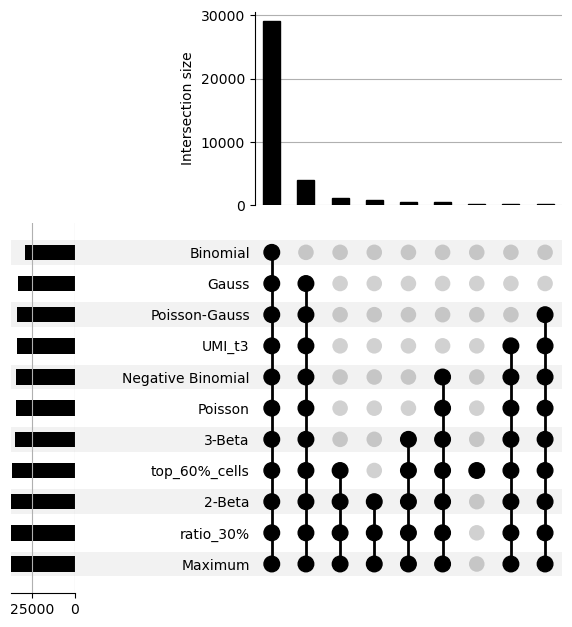

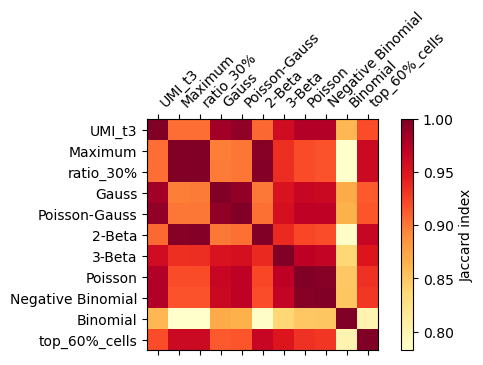

In [9]:
# Filtering for cells with single perturbations
grouped_df = perturbations.drop_duplicates()
grouped_df = grouped_df.groupby(['method', 'cell']).size().reset_index(name='pert_count')
single_perturbations = perturbations.merge(grouped_df, on=['method', 'cell'])
single_perturbations = single_perturbations[single_perturbations['pert_count'] == 1]

# Upset plot
gc.plot_intersections(single_perturbations)
plt.savefig(fig_dir + 'schraivogel_whole_gc_upset.png', dpi = 500, bbox_inches="tight")
plt.show()

# Heatmap
method_order = ['UMI_t3', 'Maximum', 'ratio_30%', 'Gauss', 'Poisson-Gauss',
                '2-Beta', '3-Beta', 'Poisson', 'Negative Binomial', 'Binomial', 'top_60%_cells']
gc.plot_intersection_heatmap(single_perturbations, method_order)
plt.savefig(fig_dir + 'schraivogel_whole_heatmap.png', dpi = 500, bbox_inches="tight")
plt.show()

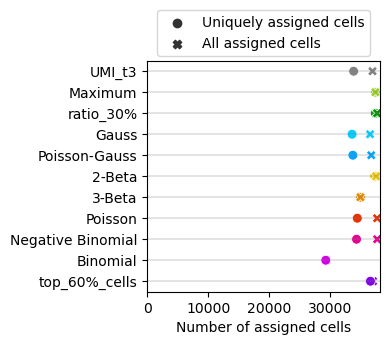

In [12]:
# Number of total and uniquely assigned cells
colors = pd.read_csv(data_dir + 'sceptre_pipeline/schraivogel_whole/colors.csv')
colors = colors.set_index('method')['colors'].to_dict()
gc.plot_n_assigned_cells(perturbations, colors)
plt.savefig(fig_dir + 'guide_calling_assigned_cells_Schraivogel_whole.png', dpi = 500, bbox_inches="tight")

In [10]:
# save single assigned cell df for usage in R
selected_df = single_perturbations.loc[:, ['cell', 'gRNA', 'method']].drop_duplicates()
selected_df.to_csv(gc_dir+'Schraivogel_whole/single_assignments_all_methods.csv', index = False)

## Schraivogel TAP-seq

In [13]:
# Varying ratios
ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
ratio_perturbations = pd.DataFrame()
for ratio in ratios: 
    ratio_cells = get_perturbations(gc_dir + 'Schraivogel_TAP/ratios/perturbations_t' + str(ratio) + '.csv', ratio * 100)
    ratio_perturbations = pd.concat([ratio_perturbations, ratio_cells])
ratio_perturbations.to_csv(gc_dir + 'Schraivogel_TAP/ratios/all_assignments.csv')

# Varying UMI threshold
UMI_ts = [2,3,4,5,6,7,8,9,10,15,20,25,30,40,50]
UMI_perturbations = pd.DataFrame()
for t in UMI_ts: 
    UMI_cells = get_perturbations(gc_dir + 'Schraivogel_TAP/UMI_t/perturbations_t' + str(t) + '.csv', t)
    UMI_perturbations = pd.concat([UMI_perturbations, UMI_cells])
UMI_perturbations.to_csv(gc_dir + 'Schraivogel_TAP/UMI_t/all_assignments.csv')
    
# Varying quantile threshold
quantile_ts = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
q_perturbations = pd.DataFrame()
for t in quantile_ts: 
    q_cells = get_perturbations(gc_dir + 'Schraivogel_TAP/quantiles/perturbations_q' + str(t) + '.csv', t * 100)
    q_perturbations = pd.concat([q_perturbations, q_cells])
q_perturbations.to_csv(gc_dir + 'Schraivogel_TAP/quantiles/all_assignments.csv')

# Filter to single assignments
ratio_perturbations = get_single_assignments(ratio_perturbations)
ratio_perturbations.to_csv(gc_dir + 'Schraivogel_TAP/ratios/single_assignments.csv')

UMI_perturbations = get_single_assignments(UMI_perturbations)
UMI_perturbations.to_csv(gc_dir + 'Schraivogel_TAP/UMI_t/single_assignments.csv')

q_perturbations = get_single_assignments(q_perturbations)
q_perturbations.to_csv(gc_dir + 'Schraivogel_TAP/quantiles/single_assignments.csv')

In [14]:
# read in assignments from various methods
file_dir = {'2-Beta': gc_dir + 'Schraivogel_TAP/2-BetaMM/perturbations.csv',
            '3-Beta': gc_dir + 'Schraivogel_TAP/3-BetaMM/perturbations.csv',
            'Binomial': gc_dir + 'Schraivogel_TAP/binomial/perturbations.csv',
            'Gauss': gc_dir + 'Schraivogel_TAP/gauss/batch1/perturbations.csv',
            'Maximum': gc_dir + 'Schraivogel_TAP/max/perturbations.csv',
            'Negative Binomial': gc_dir + 'Schraivogel_TAP/negative_binomial/perturbations.csv',
            'top_45%_cells': gc_dir + 'Schraivogel_TAP/quantiles/perturbations_q0.45.csv',
            'Poisson-Gauss': gc_dir + 'Schraivogel_TAP/replogle/perturbations.csv',
            'UMI_t4': gc_dir + 'Schraivogel_TAP/UMI_t/perturbations_t4.csv',
            'ratio_70%': gc_dir + 'Schraivogel_TAP/ratios/perturbations_t0.7.csv',
            'Poisson': gc_dir + 'Schraivogel_TAP/SCEPTRE/perturbations.csv'}

perturbations = pd.DataFrame()
for method_name, file_name in file_dir.items():
    p = get_perturbations(file_name, method_name)
    perturbations = pd.concat([perturbations, p])

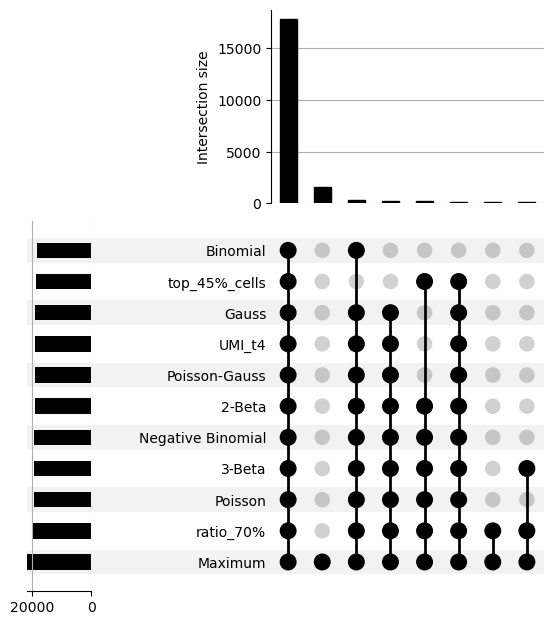

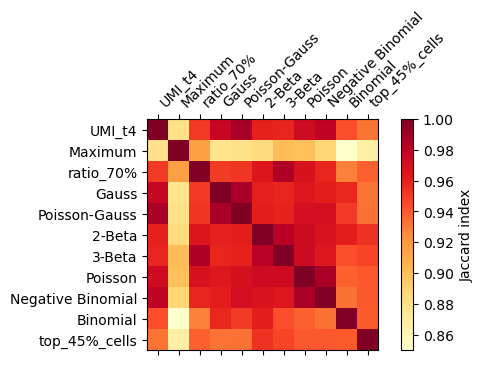

In [15]:
# Filtering for cells with single perturbations
grouped_df = perturbations.drop_duplicates()
grouped_df = grouped_df.groupby(['method', 'cell']).size().reset_index(name='pert_count')
single_perturbations = perturbations.merge(grouped_df, on=['method', 'cell'])
single_perturbations = single_perturbations[single_perturbations['pert_count'] == 1]

# Upset plot
gc.plot_intersections(single_perturbations)
plt.savefig(fig_dir + 'schraivogel_tap_gc_upset.png', dpi = 500, bbox_inches="tight")
plt.show()

# Heatmap
method_order = ['UMI_t4', 'Maximum', 'ratio_70%', 'Gauss', 'Poisson-Gauss',
                '2-Beta', '3-Beta', 'Poisson', 'Negative Binomial', 'Binomial', 'top_45%_cells']
gc.plot_intersection_heatmap(single_perturbations, method_order)
plt.savefig(fig_dir + 'schraivogel_tap_gc_heatmap.png', dpi = 500, bbox_inches="tight")
plt.show()

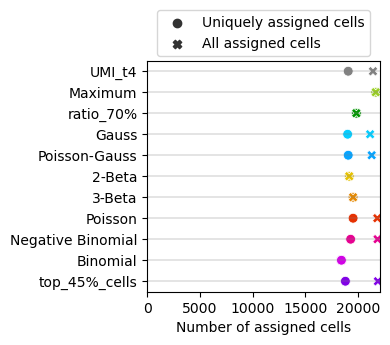

In [16]:
# Number of total and uniquely assigned cells
colors = pd.read_csv(data_dir + 'sceptre_pipeline/schraivogel_tap_grna/colors.csv')
colors = colors.set_index('method')['colors'].to_dict()
gc.plot_n_assigned_cells(perturbations, colors)
plt.savefig(fig_dir + 'guide_calling_assigned_cells_Schraivogel_tap.png', dpi = 500, bbox_inches="tight")